Recipe Master

Import dependencies

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import platform
import time
import pathlib
import os
import json
import zipfile
from google.colab import drive

# from google.colab import files

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)


Python version: 3.7.12
Tensorflow version: 2.8.0
Keras version: 2.8.0


In [ ]:
%cd /content/drive/MyDrive/NLP

/content/drive/MyDrive/NLP


Explore dataset - Recipe box dataset

In [ ]:
DEBUG = False
DEBUG_EXAMPLES = 10

In [ ]:
# Create cache folder
cache_dir = './tmp'
pathlib.Path(cache_dir).mkdir(exist_ok=True)

In [ ]:
# Download and get the path to downloaded dataset
dataset_file_name = 'recipes_raw.zip'
dataset_file_origin = 'https://storage.googleapis.com/recipe-box/recipes_raw.zip'

dataset_file_path = tf.keras.utils.get_file(
    fname = dataset_file_name,
    origin = dataset_file_origin,
    cache_dir = cache_dir,
    extract = True,
    archive_format = 'zip'

)

print(dataset_file_path)

./tmp/datasets/recipes_raw.zip


In [ ]:
# print the cache folder and check what is downloaded
!ls -la ./tmp/datasets/

total 251952
-rw------- 1 root root    20437 Mar 13 19:10 LICENSE
-rw------- 1 root root 49784325 Mar 13 19:10 recipes_raw_nosource_ar.json
-rw------- 1 root root 61133971 Mar 13 19:10 recipes_raw_nosource_epi.json
-rw------- 1 root root 93702755 Mar 13 19:10 recipes_raw_nosource_fn.json
-rw------- 1 root root 53355492 Mar 13 19:08 recipes_raw.zip


Dataset contains three files which have to be merged later to form a single dataset

In [ ]:
# Load datasets from Json and preview them

def load_dataset(silent = False):
  dataset_file_names = [
        'recipes_raw_nosource_ar.json',
        'recipes_raw_nosource_epi.json',
        'recipes_raw_nosource_fn.json',                      
  ]
  dataset = []


  for dataset_file_name in dataset_file_names:
    dataset_file_path = f'{cache_dir}/datasets/{dataset_file_name}'

    
    with open(dataset_file_path) as dataset_file:
      json_data_dict = json.load(dataset_file)
      json_data_list = list(json_data_dict.values())
      dict_keys = [key for key in json_data_list[0]]
      dict_keys.sort()
      dataset += json_data_list


      if silent == False:
        print(dataset_file_path)
        print('=================================================')
        print('Number of examples: ', len(json_data_list), '\n')
        print('Example of object keys: ', dict_keys, '\n')
        print('Example of object: ', json_data_list[0], '\n')

        print('Required Keys: \n')
        print(' title: ', json_data_list[0]['title'], '\n')
        print(' ingredients: ', json_data_list[0]['ingredients'], '\n')
        print(' instructions: ', json_data_list[0]['instructions'], '\n')
        print('\n\n')

    

  return dataset


In [ ]:
raw_dataset = load_dataset()

./tmp/datasets/recipes_raw_nosource_ar.json
Number of examples:  39802 

Example of object keys:  ['ingredients', 'instructions', 'picture_link', 'title'] 

Example of object:  {'title': 'Slow Cooker Chicken and Dumplings', 'ingredients': ['4 skinless, boneless chicken breast halves ADVERTISEMENT', '2 tablespoons butter ADVERTISEMENT', '2 (10.75 ounce) cans condensed cream of chicken soup ADVERTISEMENT', '1 onion, finely diced ADVERTISEMENT', '2 (10 ounce) packages refrigerated biscuit dough, torn into pieces ADVERTISEMENT', 'ADVERTISEMENT'], 'instructions': 'Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.\nCover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.\n', 'picture_link': '55lznCYBbs2mT8BTx6BTkLhynGHzM.S'} 

Required Keys: 

 title:  Slow Cooker Chicken and Dumplings 

 ingredients:  ['4 skinless, boneless c

In [ ]:
print('Total number of raw examples: ', len(raw_dataset))

Total number of raw examples:  125164


Preprocessing the data

1. Filtering out incomplete samples

In [ ]:
# Filter recipes which donot have either title or ingredients or instructions.
def recipe_validate_required_fields(recipe):

  req_keys = [ 'title', 'ingredients', 'instructions']

  if not recipe:
    return False

  for req_key in req_keys:
    if not recipe[req_key]:
      return False
    if type(recipe[req_key]) == list and len(recipe[req_key]) == 0:
      return False

  return True


In [ ]:
validated_dataset = [recipe for recipe in raw_dataset if recipe_validate_required_fields(recipe)]

print('Dataset size before validation: ', len(raw_dataset))
print('Dataset size after validation: ', len(validated_dataset))
print('Number of invalid recipes: ', len(raw_dataset) - len(validated_dataset))

Dataset size before validation:  125164
Dataset size after validation:  122938
Number of invalid recipes:  2226


In [ ]:
validated_dataset[0]

{'ingredients': ['4 skinless, boneless chicken breast halves ADVERTISEMENT',
  '2 tablespoons butter ADVERTISEMENT',
  '2 (10.75 ounce) cans condensed cream of chicken soup ADVERTISEMENT',
  '1 onion, finely diced ADVERTISEMENT',
  '2 (10 ounce) packages refrigerated biscuit dough, torn into pieces ADVERTISEMENT',
  'ADVERTISEMENT'],
 'instructions': 'Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.\nCover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.\n',
 'picture_link': '55lznCYBbs2mT8BTx6BTkLhynGHzM.S',
 'title': 'Slow Cooker Chicken and Dumplings'}

2. Convert recipe objects to string since RNN doesn't understand objects. The strings will be further converted to numbers before feeding into RNN

In [ ]:
STOP_WORD_TITLE = '🍔 '
STOP_WORD_INGREDIENTS = '\n🍄\n\n'
STOP_WORD_INSTRUCTIONS = '\n📖\n\n'

In [ ]:
# Convert recipe object to string
def recipe_object_to_string(recipe):
  # This Word occurs as part of the recipes. So remove it.
  noise_string = 'ADVERTISEMENT'
  title = recipe['title']
  ingredients = recipe['ingredients']
  instructions = recipe['instructions'].split('\n')

  ingredients_string = ''
  for ingredient in ingredients:
    ingredient = ingredient.replace(noise_string, '')

    if ingredient:
      ingredients_string += f'• {ingredient}\n'
    print(ingredients_string)

  instructions_string = ''

  for instruction in instructions:
    instruction = instruction.replace(noise_string, '')

    if instruction:
      instructions_string += f'▪︎ {instruction}\n'

  return f'{STOP_WORD_TITLE}{title}\n{STOP_WORD_INGREDIENTS}{ingredients_string}\n{STOP_WORD_INSTRUCTIONS}{instructions_string}'


In [ ]:
dataset_stringified = [recipe_object_to_string(recipe) for recipe in validated_dataset]

print('Stringified dataset size: ',len(dataset_stringified))

In [ ]:
dataset_stringified[0]

'🍔 Slow Cooker Chicken and Dumplings\n\n🍄\n\n• 4 skinless, boneless chicken breast halves \n• 2 tablespoons butter \n• 2 (10.75 ounce) cans condensed cream of chicken soup \n• 1 onion, finely diced \n• 2 (10 ounce) packages refrigerated biscuit dough, torn into pieces \n\n\n📖\n\n▪︎ Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.\n▪︎ Cover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.\n'

In [ ]:
for recipe_index, recipe_string in enumerate(dataset_stringified[:10]):
  print('Recipe #{}\n--------'.format(recipe_index + 1))
  print(recipe_string)
  print('\n')

Recipe #1
--------
🍔 Slow Cooker Chicken and Dumplings

🍄

• 4 skinless, boneless chicken breast halves 
• 2 tablespoons butter 
• 2 (10.75 ounce) cans condensed cream of chicken soup 
• 1 onion, finely diced 
• 2 (10 ounce) packages refrigerated biscuit dough, torn into pieces 


📖

▪︎ Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.
▪︎ Cover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.



Recipe #2
--------
🍔 Awesome Slow Cooker Pot Roast

🍄

• 2 (10.75 ounce) cans condensed cream of mushroom soup 
• 1 (1 ounce) package dry onion soup mix 
• 1 1/4 cups water 
• 5 1/2 pounds pot roast 


📖

▪︎ In a slow cooker, mix cream of mushroom soup, dry onion soup mix and water. Place pot roast in slow cooker and coat with soup mixture.
▪︎ Cook on High setting for 3 to 4 hours, or on Low setting for 8 to 9 hours.



Recipe 

In [ ]:
print(dataset_stringified[5000])

🍔 Bacon-Wrapped Jalapeno Poppers

🍄

• 1/2 cup cream cheese 
• 1/2 cup shredded sharp Cheddar cheese 
• 12 jalapeno peppers, halved lengthwise, seeds and membranes removed 
• 12 slices bacon 


📖

▪︎ Preheat oven to 400 degrees F (200 degrees C). Line a baking sheet with aluminum foil.
▪︎ Mix cream cheese and Cheddar cheese together in a bowl until evenly blended. Fill each jalapeno half with the cheese mixture. Put halves back together and wrap each stuffed pepper with a slice of bacon. Arrange bacon-wrapped peppers on the prepared baking sheet.
▪︎ Bake in the preheated oven until bacon is crispy, about 15 minutes.



Filter out large recipes

In [ ]:
# Find out te recipe length of all the recipes and plot a histogram\
recipe_lengths = []
for recipe_text in dataset_stringified:
  recipe_lengths.append(len(recipe_text))


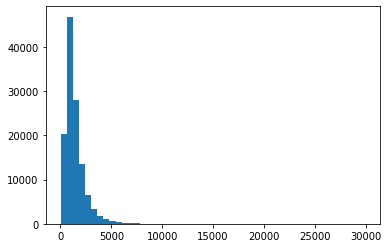

In [ ]:
plt.hist(recipe_lengths, bins = 50)
plt.show()

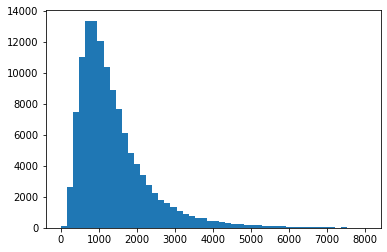

In [ ]:
plt.hist(recipe_lengths, range=(0,8000), bins=50)
plt.show()

In [ ]:
# From the above histogram, it is clear that about 80% of the recipes have a length of less than 2000
MAX_RECIPE_LENGTH = 2000
if DEBUG:
  MAX_RECIPE_LENGTH = 500

In [ ]:
def filter_recipes_by_length(recipe):
  return len(recipe) <= MAX_RECIPE_LENGTH

In [ ]:
filtered_dataset = [recipe for recipe in dataset_stringified if filter_recipes_by_length(recipe)]

print('Dataset size before filtering: ', len(dataset_stringified))
print('Dataset size after filtering: ', len(filtered_dataset))
print('Number of eliminated recipes: ', len(dataset_stringified) - len(filtered_dataset))

Dataset size before filtering:  122938
Dataset size after filtering:  100189
Number of eliminated recipes:  22749


In [ ]:
if DEBUG:
    filtered_dataset = filtered_dataset[:DEBUG_EXAMPLES]
    print('filtered_dataset.shape, ', len(filtered_dataset))

In [ ]:
TOTAL_RECIPES_NUM = len(filtered_dataset)

print('MAX_RECIPE_LENGTH: ', MAX_RECIPE_LENGTH)
print('TOTAL_RECIPES_NUM: ', TOTAL_RECIPES_NUM)

MAX_RECIPE_LENGTH:  2000
TOTAL_RECIPES_NUM:  100189


Creating Vocabulary

In [ ]:
#Indicate end of recipe
STOP_SIGN = '␣'

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    char_level = True,
    filters = '',
    lower = False,
    split = ''
)

In [ ]:
# STOP sign is not part of recipes, tokenizer should know it as well
tokenizer.fit_on_texts([STOP_SIGN])

In [ ]:
tokenizer.fit_on_texts(filtered_dataset)

In [ ]:
#Returns the tokenizer configuration as Python dictionary. 
#The word count dictionaries used by the tokenizer get serialized into plain JSON, 
#so that the configuration can be read by other projects.
tokenizer.get_config()

{'char_level': True,
 'document_count': 100190,
 'filters': '',
 'index_docs': '{"1": 100189, "165": 1, "8": 100184, "35": 83307, "29": 96720, "51": 100189, "20": 98501, "16": 100189, "23": 99204, "7": 100184, "10": 100183, "62": 35199, "6": 100175, "24": 100189, "33": 89227, "5": 100182, "32": 100189, "64": 31897, "40": 65465, "19": 99679, "66": 24368, "4": 100179, "2": 100189, "3": 100182, "34": 82431, "18": 99952, "53": 100189, "43": 67593, "14": 100138, "22": 98308, "15": 100023, "58": 40856, "27": 97825, "42": 67606, "11": 100171, "21": 100140, "28": 96364, "37": 79115, "13": 100167, "17": 99965, "52": 100189, "31": 100189, "26": 99297, "39": 79345, "41": 61936, "12": 100138, "44": 60879, "25": 97293, "9": 100181, "30": 89028, "60": 36987, "63": 32093, "38": 72113, "50": 54023, "71": 14111, "54": 46660, "45": 64262, "55": 48317, "48": 57922, "47": 47425, "36": 74689, "76": 5819, "57": 36525, "59": 38965, "49": 53739, "73": 9978, "56": 33852, "68": 18110, "61": 35346, "46": 42413, 

In [ ]:
VOCABULARY_SIZE = len(tokenizer.word_counts) + 1

print('VOCABULARY SIZE: ', VOCABULARY_SIZE)

VOCABULARY SIZE:  176


Convert characters into indices and vice versa

In [ ]:
print(tokenizer.index_word[5])
print(tokenizer.index_word[10])

o
l


In [ ]:
print(tokenizer.word_index['e'])

2


In [ ]:
js_vocabulary = tokenizer.sequences_to_texts([[word_index] for word_index in range(VOCABULARY_SIZE)])
print([char for char in js_vocabulary])

['', ' ', 'e', 'a', 't', 'o', 'n', 'i', 'r', 's', 'l', 'd', 'h', 'c', 'u', 'p', '\n', 'm', 'g', 'b', ',', '.', 'f', 'w', '•', 'k', '1', 'v', 'y', '2', '/', '▪', '︎', 'S', '4', 'C', '-', '3', 'x', 'P', '5', '0', '(', ')', 'A', 'B', 'z', 'j', 'F', 'T', 'R', '🍔', '🍄', '📖', 'I', 'M', ';', 'q', 'D', 'W', '8', 'G', '6', 'L', 'H', ':', '7', 'O', "'", 'E', 'K', '9', 'U', 'N', 'V', 'J', '®', '°', 'é', '"', 'Y', 'Q', '*', '!', 'Z', '–', '&', '%', 'ñ', 'è', '™', 'î', 'X', '?', '¿', '—', 'ç', '#', '½', 'í', '=', '’', 'â', '©', '¼', '+', '>', '$', '<', 'á', 'ó', 'ú', 'ï', 'É', 'û', ']', '[', 'ü', 'ê', 'à', '_', '\xad', '¾', '‚', '�', 'º', '⁄', 'ä', 'Ú', 'ù', '́', '}', 'ö', '{', 'ì', 'ô', '\x96', '”', '×', '˚', '»', '@', '§', '\\', '◊', '‱', '“', '‧', '\u202d', '⅛', 'å', 'ﬂ', '`', 'Á', 'ë', '\x97', '\x1a', 'ø', '⅓', '|', 'ư', '\x92', '´', '‒', 'Â', '␣', '¤', '‟', '\xa0', 'ơ', 'ă', '̀', '⅞', '€', '~', '\x95']


In [ ]:
# use tokenizer functions to convert text to indices
tokenizer.texts_to_sequences('yes🍄 ')

[[28], [2], [9], [52], [1]]

Vectorizing the dataset

In [ ]:
# texts to sequences(vectorize the data- string to numbers)
vectorized_dataset = tokenizer.texts_to_sequences(filtered_dataset)


In [ ]:
print('size of vectorized dataset: ', len(vectorized_dataset))

size of vectorized dataset:  100189


In [ ]:
print('vectorized dataset: ', vectorized_dataset[0][:15])

vectorized dataset:  [51, 1, 33, 10, 5, 23, 1, 35, 5, 5, 25, 2, 8, 1, 35]


In [ ]:
# Convert sequence to text
def recipe_sequence_to_string(recipe_sequence):
  recipe_stringified = tokenizer.sequences_to_texts([recipe_sequence])[0]
  recipe_stringified = recipe_stringified.replace('  ','_').replace(' ','').replace('_', ' ')
  print(recipe_stringified)

In [ ]:
recipe_sequence_to_string(vectorized_dataset[0])

🍔 Slow Cooker Chicken and Dumplings

🍄

• 4 skinless, boneless chicken breast halves 
• 2 tablespoons butter 
• 2 (10.75 ounce) cans condensed cream of chicken soup 
• 1 onion, finely diced 
• 2 (10 ounce) packages refrigerated biscuit dough, torn into pieces 


📖

▪︎ Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.
▪︎ Cover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.



1. Add padding to sequences -  every recipe should be of same length before inputting in RNN - Add stop word at the end

In [ ]:
for index, recipe in enumerate(vectorized_dataset[:10]):
  print('Recipe #{} length: {} '.format(index +1, len(recipe)))

Recipe #1 length: 547 
Recipe #2 length: 402 
Recipe #3 length: 672 
Recipe #4 length: 737 
Recipe #5 length: 1519 
Recipe #6 length: 741 
Recipe #7 length: 840 
Recipe #8 length: 668 
Recipe #9 length: 1265 
Recipe #10 length: 855 


In [ ]:
dataset_padded_without_stop_sign = tf.keras.preprocessing.sequence.pad_sequences(
    vectorized_dataset,
    padding = 'post',
    truncating = 'post',
    # Every recipe should have atleast one stop sign - Thats why -1
    maxlen = MAX_RECIPE_LENGTH + 1,
    value = tokenizer.texts_to_sequences([STOP_SIGN])[0]

)

In [ ]:
dataset_padded_without_stop_sign[0][601]

165

In [ ]:
dataset_vectorized_padded = tf.keras.preprocessing.sequence.pad_sequences(
    dataset_padded_without_stop_sign,
    padding = 'post',
    truncating = 'post',
    maxlen = MAX_RECIPE_LENGTH +1,
    value = tokenizer.texts_to_sequences([STOP_SIGN])[0]
)

In [ ]:
for index, recipe in enumerate(dataset_vectorized_padded[:10]):
  print('Recipe # {} length: {}'.format(index+1, len(recipe)))


Recipe # 1 length: 2001
Recipe # 2 length: 2001
Recipe # 3 length: 2001
Recipe # 4 length: 2001
Recipe # 5 length: 2001
Recipe # 6 length: 2001
Recipe # 7 length: 2001
Recipe # 8 length: 2001
Recipe # 9 length: 2001
Recipe # 10 length: 2001


In [ ]:
recipe_sequence_to_string(dataset_vectorized_padded[0])

🍔 Slow Cooker Chicken and Dumplings

🍄

• 4 skinless, boneless chicken breast halves 
• 2 tablespoons butter 
• 2 (10.75 ounce) cans condensed cream of chicken soup 
• 1 onion, finely diced 
• 2 (10 ounce) packages refrigerated biscuit dough, torn into pieces 


📖

▪︎ Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.
▪︎ Cover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.
␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣

2. Create Tensorflow dataset

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(dataset_vectorized_padded)
print(dataset)

<TensorSliceDataset element_spec=TensorSpec(shape=(2001,), dtype=tf.int32, name=None)>


In [ ]:
for recipe in dataset.take(1):
  print('Raw recipe: \n', recipe.numpy(), '\n\n\n')
  print('Stringified recipe: \n')
  recipe_sequence_to_string(recipe.numpy())

Raw recipe: 
 [ 51   1  33 ... 165 165 165] 



Stringified recipe: 

🍔 Slow Cooker Chicken and Dumplings

🍄

• 4 skinless, boneless chicken breast halves 
• 2 tablespoons butter 
• 2 (10.75 ounce) cans condensed cream of chicken soup 
• 1 onion, finely diced 
• 2 (10 ounce) packages refrigerated biscuit dough, torn into pieces 


📖

▪︎ Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.
▪︎ Cover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.
␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣

Split the samples into training and target texts

In [ ]:
def split_input_target(recipe):
  input_text = recipe[:-1]
  target_text = recipe[1:]

  return input_text, target_text

In [ ]:
dataset_targeted = dataset.map(split_input_target)
print(dataset_targeted)

<MapDataset element_spec=(TensorSpec(shape=(2000,), dtype=tf.int32, name=None), TensorSpec(shape=(2000,), dtype=tf.int32, name=None))>


In [ ]:
for input_sample, target_sample in dataset_targeted.take(1):
  print('Input sequence size: ', repr(len(input_sample.numpy())))
  print('Target sequence size: ', len(target_sample.numpy()))

  input_stringified = tokenizer.sequences_to_texts([input_sample.numpy()[:50]])[0]
  target_stringified = tokenizer.sequences_to_texts([target_sample.numpy()[:50]])[0]

  print('Input: ', repr(''.join(input_stringified)))
  print('Target: ', repr(''.join(target_stringified)))
  print(target_sample)

Input sequence size:  2000
Target sequence size:  2000
Input:  '🍔   S l o w   C o o k e r   C h i c k e n   a n d   D u m p l i n g s \n \n 🍄 \n \n •   4   s k i n l e'
Target:  '  S l o w   C o o k e r   C h i c k e n   a n d   D u m p l i n g s \n \n 🍄 \n \n •   4   s k i n l e s'
tf.Tensor([  1  33  10 ... 165 165 165], shape=(2000,), dtype=int32)


In [ ]:
for i, (input_index, target_index) in enumerate(zip(input_sample[:10], target_sample[:10])):
  print('Step {:2d}'.format(i + 1))
  print(' input: {} ({}) '.format(input_index, tokenizer.sequences_to_texts([[input_index.numpy()]])[0]))
  print(' Expected output: {} ({})'.format(target_index, tokenizer.sequences_to_texts([[target_index.numpy()]])))


Step  1
 input: 51 (🍔) 
 Expected output: 1 ([' '])
Step  2
 input: 1 ( ) 
 Expected output: 33 (['S'])
Step  3
 input: 33 (S) 
 Expected output: 10 (['l'])
Step  4
 input: 10 (l) 
 Expected output: 5 (['o'])
Step  5
 input: 5 (o) 
 Expected output: 23 (['w'])
Step  6
 input: 23 (w) 
 Expected output: 1 ([' '])
Step  7
 input: 1 ( ) 
 Expected output: 35 (['C'])
Step  8
 input: 35 (C) 
 Expected output: 5 (['o'])
Step  9
 input: 5 (o) 
 Expected output: 5 (['o'])
Step 10
 input: 5 (o) 
 Expected output: 25 (['k'])


Split the dataset into batches

In [ ]:
print(dataset_targeted)

<MapDataset element_spec=(TensorSpec(shape=(2000,), dtype=tf.int32, name=None), TensorSpec(shape=(2000,), dtype=tf.int32, name=None))>


In [ ]:
print('TOTAL_RECIPES_NUM: ', TOTAL_RECIPES_NUM)
print('MAX_RECIPE_LENGTH: ', MAX_RECIPE_LENGTH)
print('VOCABULARY_SIZE: ', VOCABULARY_SIZE)

TOTAL_RECIPES_NUM:  100189
MAX_RECIPE_LENGTH:  2000
VOCABULARY_SIZE:  176


In [ ]:
# Split the dataset into batches otherwise it will take too long to run one epoch
# Barch size
BATCH_SIZE = 64

if DEBUG:
  BATCH_SIZE = DEBUG_EXAMPLES

SHUFFLE_BUFFER_SIZE = 1000

if DEBUG:
  SHUFFLE_BUFFER_SIZE = 1

In [ ]:
from tensorflow.python.ops.gen_batch_ops import batch
if DEBUG:
  dataset_train = dataset_targeted \
        .repeat() \
        .batch(BATCH_SIZE, drop_remainder=True)


else:
  dataset_train = dataset_targeted.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).repeat()

print(dataset_train)

<RepeatDataset element_spec=(TensorSpec(shape=(64, 2000), dtype=tf.int32, name=None), TensorSpec(shape=(64, 2000), dtype=tf.int32, name=None))>


Our dataset now consists of the same two tuples of 2000 characters but now they are grouped in the batches by 64.

In [ ]:
for input_text,target_text in dataset_train.take(1):
  print('1st batch input text: ', input_text)
  print('')
  print('1st batch target text: ', target_text)

1st batch input text:  tf.Tensor(
[[ 51   1  58 ... 165 165 165]
 [ 51   1  44 ... 165 165 165]
 [ 51   1  75 ... 165 165 165]
 ...
 [ 51   1  48 ... 165 165 165]
 [ 51   1  35 ... 165 165 165]
 [ 51   1  45 ... 165 165 165]], shape=(64, 2000), dtype=int32)

1st batch target text:  tf.Tensor(
[[  1  58   5 ... 165 165 165]
 [  1  44   6 ... 165 165 165]
 [  1  75   3 ... 165 165 165]
 ...
 [  1  48  10 ... 165 165 165]
 [  1  35   5 ... 165 165 165]
 [  1  45   8 ... 165 165 165]], shape=(64, 2000), dtype=int32)


Build the Model

In [ ]:
# Let's do a quick detour and see how Embeding layer works.
# It takes several char indices sequences (batch) as an input.
# It encodes every character of every sequence to a vector of tmp_embeding_size length.
tmp_vocab_size = 10
tmp_embeding_size = 5
tmp_input_length = 8
tmp_batch_size = 2

tmp_model = tf.keras.models.Sequential()
tmp_model.add(tf.keras.layers.Embedding(
  input_dim=tmp_vocab_size,
  output_dim=tmp_embeding_size,
  input_length=tmp_input_length
))
# The model will take as input an integer matrix of size (batch, input_length).
# The largest integer (i.e. word index) in the input should be no larger than 9 (tmp_vocab_size).
# Now model.output_shape == (None, 10, 64), where None is the batch dimension.
tmp_input_array = np.random.randint(
  low=0,
  high=tmp_vocab_size,
  size=(tmp_batch_size, tmp_input_length)
)
tmp_model.compile('rmsprop', 'mse')
tmp_output_array = tmp_model.predict(tmp_input_array)

print('tmp_input_array shape:', tmp_input_array.shape)
print('tmp_input_array:')
print(tmp_input_array)
print()
print('tmp_output_array shape:', tmp_output_array.shape)
print('tmp_output_array:')
print(tmp_output_array)

tmp_input_array shape: (2, 8)
tmp_input_array:
[[9 9 4 2 6 9 2 8]
 [7 0 1 2 0 7 6 3]]

tmp_output_array shape: (2, 8, 5)
tmp_output_array:
[[[ 0.00129228  0.04238231 -0.03852072  0.03326161 -0.03703739]
  [ 0.00129228  0.04238231 -0.03852072  0.03326161 -0.03703739]
  [-0.02112317 -0.04210166  0.01041996 -0.02425625 -0.04058729]
  [-0.00336716  0.04444572  0.01604604  0.03612483  0.01079363]
  [ 0.00496712  0.04243251 -0.00162191 -0.03108914 -0.03281802]
  [ 0.00129228  0.04238231 -0.03852072  0.03326161 -0.03703739]
  [-0.00336716  0.04444572  0.01604604  0.03612483  0.01079363]
  [ 0.01247974  0.01482687  0.04120224  0.03581747  0.04310406]]

 [[-0.04775934  0.00529168  0.03793037 -0.01055773 -0.0461975 ]
  [ 0.03137299 -0.01784648  0.04390283  0.01419495 -0.01970064]
  [-0.00316257  0.04617742 -0.0006431  -0.03981415  0.02134755]
  [-0.00336716  0.04444572  0.01604604  0.03612483  0.01079363]
  [ 0.03137299 -0.01784648  0.04390283  0.01419495 -0.01970064]
  [-0.04775934  0.00529168 

Model 1

In [ ]:
# Length of the vocabulary in chars.
vocab_size = VOCABULARY_SIZE

# The embedding dimension.
embedding_dim = 256

# Number of RNN units.
rnn_units = 1024

In [ ]:
def build_model_1(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        batch_input_shape=[batch_size, None]
    ))

    model.add(tf.keras.layers.LSTM(
        units=rnn_units,
        return_sequences=True,
        stateful=True,
        recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(tf.keras.layers.Dense(vocab_size))
    
    return model

In [ ]:
model_1 = build_model_1(vocab_size, embedding_dim, rnn_units, BATCH_SIZE)

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (64, None, 256)           45056     
                                                                 
 lstm (LSTM)                 (64, None, 1024)          5246976   
                                                                 
 dense (Dense)               (64, None, 176)           180400    
                                                                 
Total params: 5,472,432
Trainable params: 5,472,432
Non-trainable params: 0
_________________________________________________________________


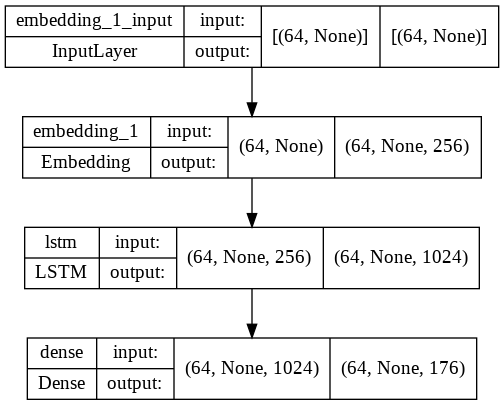

In [ ]:
tf.keras.utils.plot_model(
    model_1,
    show_shapes=True,
    show_layer_names=True,
    to_file='model_1.png'
)

Try the model

In [ ]:
for input_example_batch, target_example_batch in dataset_train.take(1):
    example_batch_predictions = model_1(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 2000, 176) # (batch_size, sequence_length, vocab_size)


In [ ]:
print('Prediction for the 1st letter of the batch 1st sequense:')
print(example_batch_predictions[0, 0])

Prediction for the 1st letter of the batch 1st sequense:
tf.Tensor(
[ 1.3170242e-03 -1.9946443e-03 -2.9319585e-03  7.1154740e-03
 -3.6552341e-03 -2.9564209e-03  5.1481314e-03 -1.7322458e-03
  7.9918449e-04  3.2786150e-03 -4.4312915e-03  5.5925705e-04
  5.8142049e-04  4.1247185e-04  1.6218041e-03 -1.7702642e-03
  1.4598228e-03  1.6422370e-03  8.0315652e-04 -1.1226255e-03
 -1.5403754e-03  4.6747882e-04  4.0517156e-03  7.5672613e-04
 -8.1707294e-05 -1.4626166e-03  4.9122516e-03  3.1828389e-03
 -7.4914569e-04  2.7930059e-03 -8.7106349e-03 -1.0608442e-03
  1.3477696e-04 -8.7031041e-04 -4.8987684e-03  4.6738857e-04
  2.6058659e-04  4.7074240e-03 -2.6079291e-03  5.8178701e-03
 -4.2194850e-03 -1.0493821e-03 -1.6844902e-03  2.3536426e-03
  9.1522833e-04  2.1841947e-04 -1.6443235e-03  1.9096758e-04
 -4.5774011e-03 -5.3893654e-03 -2.3961025e-03 -1.1576145e-03
 -9.7447950e-03  4.6252934e-04 -3.9010956e-03 -4.3124324e-03
 -4.8634312e-03  2.5356137e-03 -7.8941071e-03 -2.3215988e-03
  2.9296887e-03 -

In [ ]:
sampled_indices = tf.random.categorical(
    logits=example_batch_predictions[0],
    num_samples=1
)

sampled_indices.shape

TensorShape([2000, 1])

In [ ]:
sampled_indices = tf.squeeze(
    input=sampled_indices,
    axis=-1
).numpy()

sampled_indices.shape

(2000,)

In [ ]:
sampled_indices[:100]

array([ 99, 143, 137,  58,  45, 172, 161, 128, 148,  99, 112,  92, 113,
        26, 164, 142,  55, 143, 155, 157, 120,  31,  14,  48,  79, 120,
        65, 163, 133, 124,  71, 115, 169, 132,  95,  20,  66, 175,  23,
        40,  72, 171, 134,  11, 111,  49,  19, 164,  51, 138, 156,  85,
       144,  30, 157, 169,  99,  16,  77, 128,  41,  98,  93, 160, 160,
       118, 158,  23, 142, 119, 170, 100,  51,  92, 124,  38, 107,  91,
        66, 146,  65,  75,  54, 131,  15, 160, 113, 118,  11,  35,  32,
        94, 118, 121, 112, 141,  61,  94, 159, 147])

In [ ]:
print('Input:\n', repr(''.join(tokenizer.sequences_to_texts([input_example_batch[0].numpy()[:50]]))))
print()
print('Next char prediction:\n', repr(''.join(tokenizer.sequences_to_texts([sampled_indices[:50]]))))

Input:
 '🍔   H a s h   B r o w n   C a s s e r o l e   I I \n \n 🍄 \n \n •   1   ( 2   p o u n d )   p a c k a g'

Next char prediction:
 'í \\ ” D B ⅞ \x92 Ú \u202d í ï X É 1 Â § M \\ \x97 ø _ ▪ u F " _ : ‒ { � 9 ] ơ ö — , 7 \x95 w 5 U ̀ ì d ú T b Â 🍔 ×'


Try the model for variable input

In [ ]:
for input_example_batch_custom, target_example_batch_custom in dataset_train.take(1):
    random_input = np.zeros(shape=(BATCH_SIZE, 10))
    example_batch_predictions_custom = model_1(random_input)
    print('Prediction shape: ', example_batch_predictions_custom.shape, "# (batch_size, sequence_length, vocab_size)\n")
    print('Custom length input: ')
    print(random_input)

Prediction shape:  (64, 10, 176) # (batch_size, sequence_length, vocab_size)

Custom length input: 
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0

Optimizer and loss function

Train the model

In [ ]:
# An objective function.
# The function is any callable with the signature scalar_loss = fn(y_true, y_pred).
def loss(labels, logits):
    entropy = tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,
      y_pred=logits,
      from_logits=True
    )
    
    return entropy

example_batch_loss = loss(target_example_batch, example_batch_predictions)

print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss.shape:      ", example_batch_loss.shape)
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 2000, 176)  # (batch_size, sequence_length, vocab_size)
scalar_loss.shape:       (64, 2000)
scalar_loss:       5.1735654


In [ ]:
# Configure check points
# !rm -rf './tmp/checkpoints'

In [ ]:
# Directory where the checkpoints will be saved.
checkpoint_dir = 'tmp/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

In [ ]:
def download_latest_checkpoint(zip_only=True):
    latest_checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
    latest_checkpoint_name = os.path.split(latest_checkpoint_path)[-1]
    latest_checkpoint_zip_name = latest_checkpoint_name + '.zip'
    
    print('latest_checkpoint_path: ', latest_checkpoint_path)
    print('latest_checkpoint_name: ', latest_checkpoint_name)
    print('---\n')

    print('Checkpoint files:')
    with zipfile.ZipFile(latest_checkpoint_zip_name, mode='w') as zip_obj:
        for folder_name, subfolders, filenames in os.walk(checkpoint_dir):
            for filename in filenames:
                if filename.startswith(latest_checkpoint_name):
                        print('  - ' + filename)
                        file_path = os.path.join(folder_name, filename)
                        zip_obj.write(file_path, os.path.basename(file_path))
    print('---\n')
    print('Zipped to: ', latest_checkpoint_zip_name)

    if not zip_only:
        files.download(latest_checkpoint_zip_name)

In [ ]:
def model_weights_from_latest_checkpoint(model):
    latest_checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)

    if not latest_checkpoint_path:
        print('Latest checkpoint was not found. Using model as is.')
        return model

    print('latest_checkpoint_path: ', latest_checkpoint_path)

    model.load_weights(latest_checkpoint_path)

    return model

In [ ]:
def initial_epoch_from_latest_checkpoint():
    latest_checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)

    if not latest_checkpoint_path:
        print('Latest checkpoint was not found. Starting from epoch #0')
        return 0

    print('latest_checkpoint_path: ', latest_checkpoint_path)

    latest_checkpoint_name = os.path.split(latest_checkpoint_path)[-1]
    print('latest_checkpoint_name: ', latest_checkpoint_name)

    latest_checkpoint_num = latest_checkpoint_name.split('_')[-1]
    print('latest_checkpoint_num: ', latest_checkpoint_num)

    return int(latest_checkpoint_num)

In [ ]:
def unzip_checkpoint(checkpoint_zip_path):
    if not os.path.exists(checkpoint_zip_path):
        print('Cannot find a specified file')
        return

    os.makedirs(checkpoint_dir, exist_ok=True)
    with zipfile.ZipFile(checkpoint_zip_path, 'r') as zip_obj:
        zip_obj.extractall(checkpoint_dir)

    %ls -la ./tmp/checkpoints

In [ ]:
# Unzip uploaded checkpoint to checkpoints folder if needed
# unzip_checkpoint('ckpt_10.zip')

In [ ]:
# Loading the latest training data from checkpoints if needed.
# model_1 = model_weights_from_latest_checkpoint(model_1)

In [ ]:
# Loading weights from H5 file if needed.
# model_1.load_weights('recipe_generation_rnn_batch_64.h5')

Configure callback - To stop the training

In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    monitor='loss',
    restore_best_weights=True,
    verbose=1
)

In [ ]:
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

Execute training

In [ ]:
INITIAL_EPOCH  = initial_epoch_from_latest_checkpoint()
EPOCHS_DELTA = 1
EPOCHS = INITIAL_EPOCH + EPOCHS_DELTA
STEPS_PER_EPOCH = 1500

print('\n')
print('INITIAL_EPOCH:   ', INITIAL_EPOCH)
print('EPOCHS_DELTA:    ', EPOCHS_DELTA)
print('EPOCHS:          ', EPOCHS)
print('STEPS_PER_EPOCH: ', STEPS_PER_EPOCH)

Latest checkpoint was not found. Starting from epoch #0


INITIAL_EPOCH:    0
EPOCHS_DELTA:     1
EPOCHS:           1
STEPS_PER_EPOCH:  1500


In [ ]:
history_1 = {}
# history_1 = {} if not history_1 else history_1
print(history_1)

{}


In [ ]:
model_1.compile(optimizer = 'Adam', loss=loss)

In [ ]:
history_1[INITIAL_EPOCH] = model_1.fit(
    x=dataset_train,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    initial_epoch=INITIAL_EPOCH,
    callbacks=[
        checkpoint_callback,
        early_stopping_callback
    ]
)

model_name = 'recipe_generation_rnn_raw_' + str(INITIAL_EPOCH) + '.h5'
model_1.save(model_name, save_format='h5')

download_latest_checkpoint(zip_only=True)

1500/1500 [==============================] - 1440s 954ms/step - loss: 0.6413
latest_checkpoint_path:  tmp/checkpoints/ckpt_1
latest_checkpoint_name:  ckpt_1
---

Checkpoint files:
  - ckpt_1.data-00000-of-00001
  - ckpt_1.index
---

Zipped to:  ckpt_1.zip


In [ ]:
print(history_1)

{0: <keras.callbacks.History object at 0x7f448029da50>}


In [ ]:
#visualize training
def render_training_history(training_history):
    if 'history' in training_history:
        loss = training_history.history['loss']
    else:
        loss = []
        for initial_epoch in training_history:
            loss += training_history[initial_epoch].history['loss']

    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

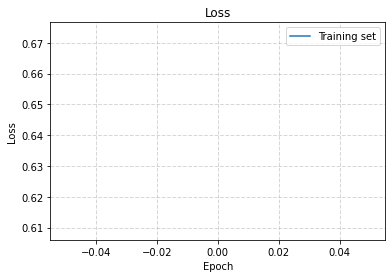

In [ ]:
render_training_history(history_1)

Restore latest check point

In [ ]:
tf.train.latest_checkpoint(checkpoint_dir)

'tmp/checkpoints/ckpt_1'

In [ ]:
simplified_batch_size = 1

model_1_simplified = build_model_1(vocab_size, embedding_dim, rnn_units, simplified_batch_size)

model_1_simplified.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model_1_simplified.build(tf.TensorShape([simplified_batch_size, None]))

In [ ]:
model_1_simplified.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (1, None, 256)            45056     
                                                                 
 lstm_1 (LSTM)               (1, None, 1024)           5246976   
                                                                 
 dense_1 (Dense)             (1, None, 176)            180400    
                                                                 
Total params: 5,472,432
Trainable params: 5,472,432
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_1_simplified.input_shape

(1, None)

In [ ]:
# num_generate
# - number of characters to generate.
#
# temperature
# - Low temperatures results in more predictable text.
# - Higher temperatures results in more surprising text.
# - Experiment to find the best setting.
def generate_text(model, start_string, num_generate = 1000, temperature=1.0):
    # Evaluation step (generating text using the learned model)
    
    padded_start_string = STOP_WORD_TITLE + start_string

    # Converting our start string to numbers (vectorizing).
    input_indices = np.array(tokenizer.texts_to_sequences([padded_start_string]))

    # Empty string to store our results.
    text_generated = []

    # Here batch size == 1.
    model.reset_states()
    for char_index in range(num_generate):
        predictions = model(input_indices)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # Using a categorical distribution to predict the character returned by the model.
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(
            predictions,
            num_samples=1
        )[-1,0].numpy()

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state.
        input_indices = tf.expand_dims([predicted_id], 0)
        
        next_character = tokenizer.sequences_to_texts(input_indices.numpy())[0]

        text_generated.append(next_character)

    return (padded_start_string + ''.join(text_generated))

In [ ]:
def generate_combinations(model):
    recipe_length = 1000
    try_letters = ['', '\n', 'A', 'B', 'C', 'O', 'L', 'Mushroom', 'Apple', 'Slow', 'Christmass', 'The', 'Banana', 'Homemade']
    try_temperature = [1.0, 0.8, 0.4, 0.2]

    for letter in try_letters:
        for temperature in try_temperature:
            generated_text = generate_text(
                model,
                start_string=letter,
                num_generate = recipe_length,
                temperature=temperature
            )
            print(f'Attempt: "{letter}" + {temperature}')
            print('-----------------------------------')
            print(generated_text)
            print('\n\n')


In [ ]:
generate_combinations(model_1_simplified)

Attempt: "" + 1.0
-----------------------------------
🍔 d§1>û\í@Â[⅓‒ïáQ=⅛‱‚v␣`Á y`45 deegrees fratee
• 1/4 teaspoon ground cinnamon
• 1/2 teaspoon papriked sets and seeds lemon
• 1/2 tz 1/4 cup water
• 1 cup fizel peanuts, finely julien
• Coarse slices


📖

▪︎ Line a pot over mixed on undired baysley. Put together in an oil avaparc ham mix.
▪︎ Add the flour onto the pan. Drain pastry and chill for 1 to 2 hours or until tender and smaking with a medium bowl and simmer for 5 minutes. Add 1/4 cup fry into cheese and refrigerate until ready to but lett well. Best together mablers on a bakinus eress, and tart layers of crarberries and threese you seeven.
␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣

Save the model

In [ ]:
model_name = 'recipe_generation_rnn.h5'
model_1_simplified.save(model_name, save_format='h5')